In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import warnings

from tensorflow import keras
from tensorflow.keras import layers

warnings.filterwarnings('ignore')
%matplotlib inline

### 1. 构造数据集
- 1. 定义正弦函数
- 2. 选定历史数据构造时序数据

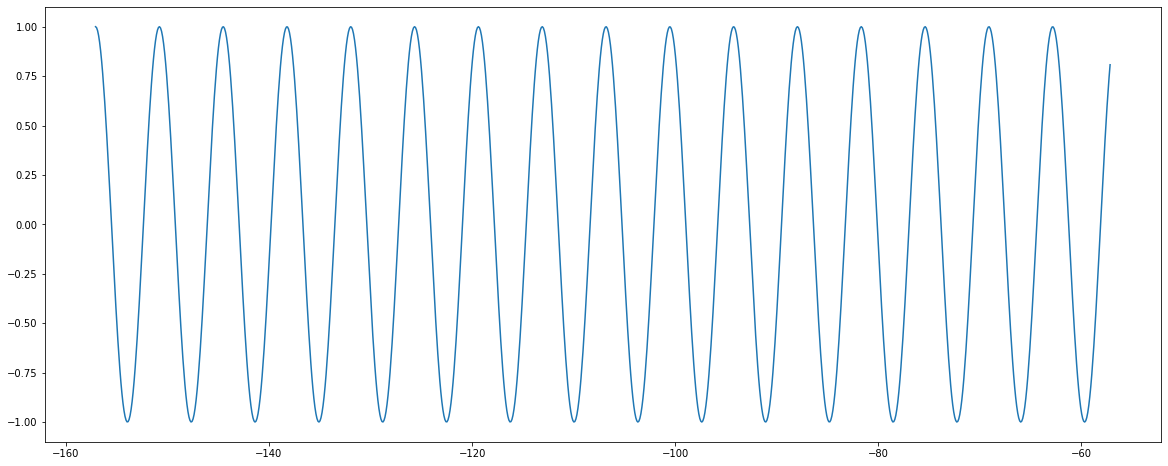

In [67]:
def ground_func(x):
    return np.cos(x)

def build_data(sequence_data, n_steps):
    X, y = [], []
    seq_len = len(sequence_data)
    for start_idx in tqdm_notebook(range(seq_len), total=seq_len-n_steps):
        end_idx = start_idx + n_steps
        if end_idx >= seq_len:
            break
        cur_x = sequence_data[start_idx: end_idx]
        cur_y = sequence_data[end_idx]
        X.append(cur_x)
        y.append(cur_y)
    X = np.array(X)
    y = np.array(y)
    print(X.shape)
    # X.shape get number of examples and n_steps, but LSTM need inputs like (batch, n_steps, n_features),
    X = X.reshape(*X.shape, 1)
    return X, y 

x_axis = np.arange(-50 * np.pi, 50 * np.pi, 0.1)
sequence_data = ground_func(x_axis)
plt.figure(figsize=(20, 8))
plt.plot(x_axis[:1000], sequence_data[:1000])

In [69]:
n_steps = 20
X, y = build_data(sequence_data, n_steps)

  0%|          | 0/3122 [00:00<?, ?it/s]

(3122, 20)


### 2. 搭建模型
- 1. 选择合适的 hidden size
- 2. 选择合适的激活函数，比如 relu、tanh
- 3. 优化器选择 sgd、adam 等等
- 4. 损失函数选择交叉熵损失函数(cross_entropy) 还是均方误差(mse) 等等

In [59]:
def create_lstm_model_1(input_size, output_size,lstm_units=32, activation='tanh'):
    inputs = layers.Input(shape=input_size)
    outputs = layers.LSTM(units=lstm_units, activation=activation)(inputs)
    outputs = layers.Dense(output_size, activation=activation)(outputs)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

def create_lstm_model_2(input_size, output_size,lstm_units=32, activation='tanh'):
    model = keras.Sequential()
    model.add(layers.Input(shape=input_size))
    model.add(layers.LSTM(lstm_units, activation=activation))
    model.add(layers.Dense(output_size, activation=activation))
    model.compile(optimizer='adam', loss='mse')
    return model

In [60]:
# 初始化模型并打印相关信息
model1 = create_lstm_model_1(input_size=(20, 1), output_size=1)
model2 = create_lstm_model_2(input_size=(20, 1), output_size=1)
model1.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 20, 1)]           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                4352      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


### 3. 训练模型


Epoch 1/25
3122/3122 [==============================] - 1s 473us/sample - loss: 0.2391
Epoch 2/25
3122/3122 [==============================] - 1s 247us/sample - loss: 0.0046
Epoch 3/25
3122/3122 [==============================] - 1s 230us/sample - loss: 7.6372e-04
Epoch 4/25
3122/3122 [==============================] - 1s 234us/sample - loss: 2.8452e-04
Epoch 5/25
3122/3122 [==============================] - 1s 219us/sample - loss: 1.0936e-04
Epoch 6/25
3122/3122 [==============================] - 1s 234us/sample - loss: 7.0798e-05
Epoch 7/25
3122/3122 [==============================] - 1s 254us/sample - loss: 5.3521e-05
Epoch 8/25
3122/3122 [==============================] - 1s 240us/sample - loss: 4.4076e-05
Epoch 9/25
3122/3122 [==============================] - 1s 225us/sample - loss: 3.9060e-05
Epoch 10/25
3122/3122 [==============================] - 1s 225us/sample - loss: 5.6226e-05
Epoch 11/25
3122/3122 [==============================] - 1s 231us/sample - loss: 4.5566e-05
Epoch

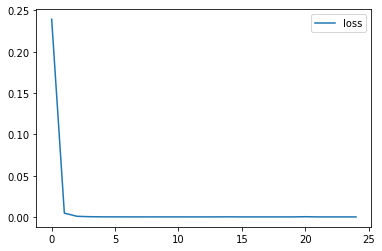

In [61]:
# 尝试更改 epochs ，加入 callbacks，例如 EarlyStopping (https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)
history = model1.fit(X, y, batch_size=32, epochs=25, verbose=1)
plt.plot(history.history['loss'], label='loss')
plt.legend(loc='upper right')

### 4. 预测
- 1. 定义新的函数 (sine/cosine)
- 2. 利用训练好的模型进行预测
- 3. 将模型预测结果和真实值进行可视化对比

In [62]:
def test_func(x):
    return np.sin(x)

In [65]:
test_x_axis = np.arange(0, 10 * np.pi, 0.1)
test_sequence_data = test_func(test_x_axis)
# 利用初始的 n_steps 个历史数据开始预测，后面的数据依次利用预测出的数据作为历史数据进行进一步预测
y_preds = test_sequence_data[:n_steps]
for i in tqdm_notebook(range(len(test_x_axis) - n_steps)):
    model_input = y_preds[i: i + n_steps]
    model_input = model_input.reshape((1, n_steps, 1))
    y_pred = model1.predict(model_input)[0]
    y_preds = np.append(y_preds, y_pred)

  0%|          | 0/295 [00:00<?, ?it/s]

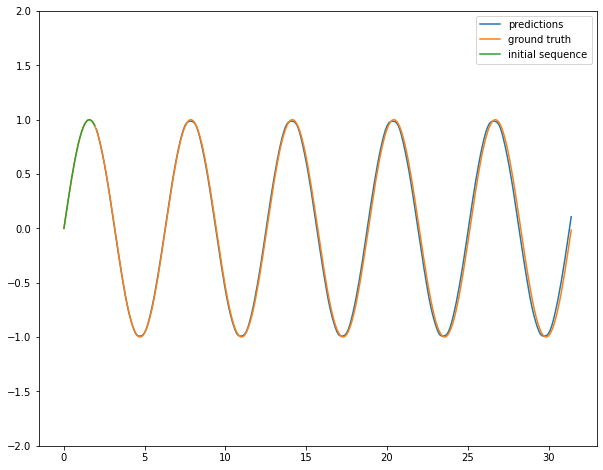

In [66]:
def show():
    plt.figure(figsize=(10, 8))
    plt.plot(test_x_axis[n_steps:], y_preds[n_steps:], label='predictions')
    plt.plot(test_x_axis, test_sequence_data, label='ground truth')
    plt.plot(test_x_axis[:n_steps], y_preds[:n_steps], label='initial sequence')
    plt.legend(loc='upper right')
    plt.ylim(-2, 2)
    plt.show()
show()